# ***Classification automatique sur les 5 tags***

Je réutilise la colonne contenant les textes tokenisés sans les noms des personnages et le modèle LinearSVC, car c'est la configuration qui obtenait les meilleurs résultats sur Angst, Fluff et Hurt/Comfort.

# Imports

In [ ]:
# Imports nécessaires

%matplotlib inline

# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')
import string
import time
from sklearn import metrics
from sklearn import model_selection
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import re

# Pour la visualisation des pipelines sklearn
set_config(display='diagram')


# Chargement des données

In [ ]:
# Création d'un dossier appelé data
!mkdir data
# Téléchargement du fichier dev dans le dossier data
!wget -P data https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/classification/fanfics_dev.csv
# Téléchargement du fichier test dans le dossier data
!wget -P data https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/classification/fanfics_test.csv

--2025-03-25 20:02:40--  https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/classification/fanfics_dev.csv
Resolving gitlab.unistra.fr (gitlab.unistra.fr)... 130.79.254.48
Connecting to gitlab.unistra.fr (gitlab.unistra.fr)|130.79.254.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471015192 (449M) [text/plain]
Saving to: ‘data/fanfics_dev.csv’

fanfics_dev.csv     100%[===================>] 449.19M  3.62MB/s    in 37s     

2025-03-25 20:03:18 (12.1 MB/s) - ‘data/fanfics_dev.csv’ saved [471015192/471015192]

--2025-03-25 20:03:18--  https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/classification/fanfics_test.csv
Resolving gitlab.unistra.fr (gitlab.unistra.fr)... 130.79.254.48
Connecting to gitlab.unistra.fr (gitlab.unistra.fr)|130.79.254.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138972746 (133M) [text/plain]
Saving to: ‘data/fanfics_test.csv’

fanfics_test.csv    100%[================

In [ ]:
# Lecture des fichiers
dtypes = {'title': 'object',
          'tokenised_no_chara': 'object',
          'tag': 'category'}

df_dev = pd.read_csv('data/fanfics_dev.csv', dtype=dtypes)
df_test = pd.read_csv('data/fanfics_test.csv', dtype=dtypes)

In [ ]:
# Données sources
X_dev = df_dev['tokenised_no_chara']

# Données à prédire
y_dev = df_dev.tag

# Vectorisation TF-IDF

In [ ]:
# Découpage des textes en listes de mots
def split_text(text) :
  # Les textes ayant déjà été pré-tokénisés, il suffit de les découper au niveau des espaces
  return text.split(' ')

In [ ]:
# Objet TfidfVectorizer
text_vectorizer = TfidfVectorizer(tokenizer=split_text, min_df=0.01)

# Entrainement du modèle avec pondération des classes
Comme les tags "Friends to lovers" et "Enemies to lovers" sont beaucoup moins représentés que les autres tags, j'essaie de pondérer les classes pour pallier ce déséquilibre.

In [ ]:
# Calculer les poids des classes en utilisant les classes de y_dev_complet
class_weights = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(y_dev),
                                    y=y_dev)

# Créer un dictionnaire de poids de classes avec toutes les classes de y_dev_complet
class_weights_dict = dict(zip(np.unique(y_dev), class_weights))

# Validation croisée à 5 plis
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Modèle à entraîner avec pondération des classes
model = LinearSVC(C=1, loss='squared_hinge', penalty='l2', tol=0.01,
                  class_weight=class_weights_dict)

# Création de la pipeline pour le modèle
model_pipeline = make_pipeline(text_vectorizer, model)

# Validation croisée
y_pred = model_selection.cross_val_predict(model_pipeline,
                                           X_dev,
                                           y_dev,
                                           cv=kfold)
# Affichage des résultats
print("LinearSVC")
print(classification_report(y_dev, y_pred))

# Calcul et affichage du F1-score macro
f1 = metrics.f1_score(y_dev, y_pred, average='macro')
print(f"Macro F1-score: {f1:.4f}")

LinearSVC
                   precision    recall  f1-score   support

            Angst       0.71      0.67      0.69       727
Enemies to lovers       0.31      0.32      0.31       175
            Fluff       0.69      0.69      0.69       617
Friends to lovers       0.39      0.42      0.40       321
     Hurt/Comfort       0.57      0.58      0.57       716

         accuracy                           0.59      2556
        macro avg       0.53      0.53      0.53      2556
     weighted avg       0.60      0.59      0.59      2556

Macro F1-score: 0.5334


Les résultats ne sont pas optimaux.

# Entrainement avec rééchantillonnage
J'essaie aussi le rééchantillonage avec SMOTE

In [ ]:
# Vectorisation TF-IDF des textes
X_vectorized = text_vectorizer.fit_transform(X_dev)

# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_dev)

# Refaire l'entraînement avec LinearSVC
model_smote = LinearSVC(C=10, loss='squared_hinge', penalty='l2', tol=0.01)
model_smote.fit(X_resampled, y_resampled)

# Prédictions
y_pred_smote = model_smote.predict(text_vectorizer.transform(X_dev))
print(classification_report(y_dev, y_pred_smote))


                   precision    recall  f1-score   support

            Angst       1.00      0.99      0.99       727
Enemies to lovers       0.98      0.98      0.98       175
            Fluff       0.99      1.00      1.00       617
Friends to lovers       0.97      1.00      0.98       321
     Hurt/Comfort       1.00      0.99      0.99       716

         accuracy                           0.99      2556
        macro avg       0.99      0.99      0.99      2556
     weighted avg       0.99      0.99      0.99      2556



Les résultats sont trop parfaits et sont sûrement dûs à du sur-apprentissage.

# Pondération et rééchantillonnage

Je teste une combinaison des deux.

In [ ]:
# Calculer les poids des classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_dev),
                                     y=y_dev)
class_weights_dict = dict(zip(np.unique(y_dev), class_weights))

# Vectorisation TF-IDF des textes
X_vectorized = text_vectorizer.fit_transform(X_dev)

# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_dev)

# Modèle à entraîner avec pondération des classes et données rééchantillonnées
model = LinearSVC(C=10, loss='squared_hinge', penalty='l2', tol=0.01,
                  class_weight=class_weights_dict)

# Création de la pipeline pour le modèle
model_pipeline = make_pipeline(model)

# Validation croisée
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
y_pred = cross_val_predict(model_pipeline, X_resampled, y_resampled, cv=kfold)

# Affichage des résultats
print("LinearSVC avec SMOTE et pondération des classes")
print(classification_report(y_resampled, y_pred))

# Calcul et affichage du F1-score macro
f1 = f1_score(y_resampled, y_pred, average='macro')
print(f"Macro F1-score: {f1:.4f}")

LinearSVC avec SMOTE et pondération des classes
                   precision    recall  f1-score   support

            Angst       0.74      0.61      0.67       727
Enemies to lovers       0.81      0.99      0.89       727
            Fluff       0.80      0.72      0.76       727
Friends to lovers       0.69      0.91      0.78       727
     Hurt/Comfort       0.64      0.48      0.55       727

         accuracy                           0.74      3635
        macro avg       0.74      0.74      0.73      3635
     weighted avg       0.74      0.74      0.73      3635

Macro F1-score: 0.7294


Je semble obtenir des résultats meilleurs.

# Test

## Apprentissage des données

In [ ]:
# Données sources
X_test = df_test['tokenised_no_chara']

# Données à prédire
y_test = df_test.tag

### Fonction qui réentraine et évalue le modèle (choix pondération/échantillonnage)
La fonction permet d'entrainer puis évaluer LinearSVC en entrant les paramètres d'entrainement x_dev et y_dev et de test x_test et y_test et de choisir si on utilise de la pondération et/ou du rééchantillonnage.


In [ ]:
def train_and_evaluate(X_dev, y_dev, X_test, y_test, use_smote=False, use_class_weight=False, title=""):
    # Vectorisation
    X_dev_vectorized = text_vectorizer.fit_transform(X_dev)
    X_test_vectorized = text_vectorizer.transform(X_test)

    if use_smote:
        smote = SMOTE(random_state=42)
        X_dev_vectorized, y_dev = smote.fit_resample(X_dev_vectorized, y_dev)

    class_weights_dict = None
    if use_class_weight:
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_dev), y=y_dev)
        class_weights_dict = dict(zip(np.unique(y_dev), class_weights))

    model = LinearSVC(C=1, loss='squared_hinge', penalty='l2', tol=0.01, class_weight=class_weights_dict)
    model_pipeline = make_pipeline(model)
    model_pipeline.fit(X_dev_vectorized, y_dev)

    y_test_pred = model_pipeline.predict(X_test_vectorized)

    # Afficher le rapport de classification
    print(f"📊 {title}")
    print(classification_report(y_test, y_test_pred))

    # Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Prédictions")
    plt.ylabel("Réelles")
    plt.title(f"Matrice de Confusion - {title}")
    plt.show()

### Affichage des résultats sur les données de test

Pour les trois combinaison utilisées lors de l'entrainement précédent.

=== Rapport de Test: Pondération ===
📊 Pondération des classes
                   precision    recall  f1-score   support

            Angst       0.62      0.37      0.46       203
Enemies to lovers       0.27      0.29      0.28        94
            Fluff       0.49      0.51      0.50       183
Friends to lovers       0.44      0.59      0.50       173
     Hurt/Comfort       0.50      0.51      0.51       216

         accuracy                           0.47       869
        macro avg       0.46      0.45      0.45       869
     weighted avg       0.49      0.47      0.47       869



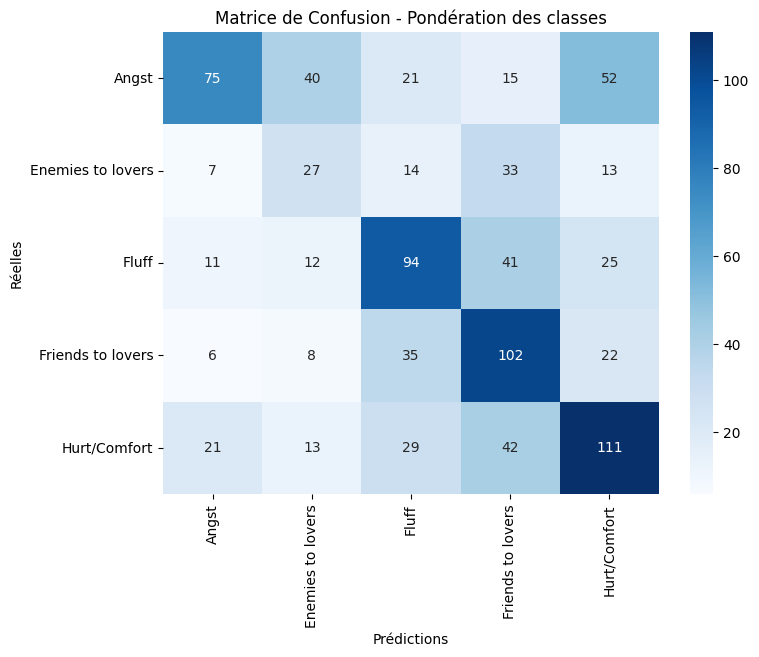

=== Rapport de Test: Échantillonnage ===
📊 Échantillonnage avec SMOTE
                   precision    recall  f1-score   support

            Angst       0.61      0.39      0.48       203
Enemies to lovers       0.30      0.33      0.31        94
            Fluff       0.49      0.50      0.50       183
Friends to lovers       0.41      0.66      0.50       173
     Hurt/Comfort       0.53      0.40      0.46       216

         accuracy                           0.47       869
        macro avg       0.47      0.46      0.45       869
     weighted avg       0.49      0.47      0.46       869



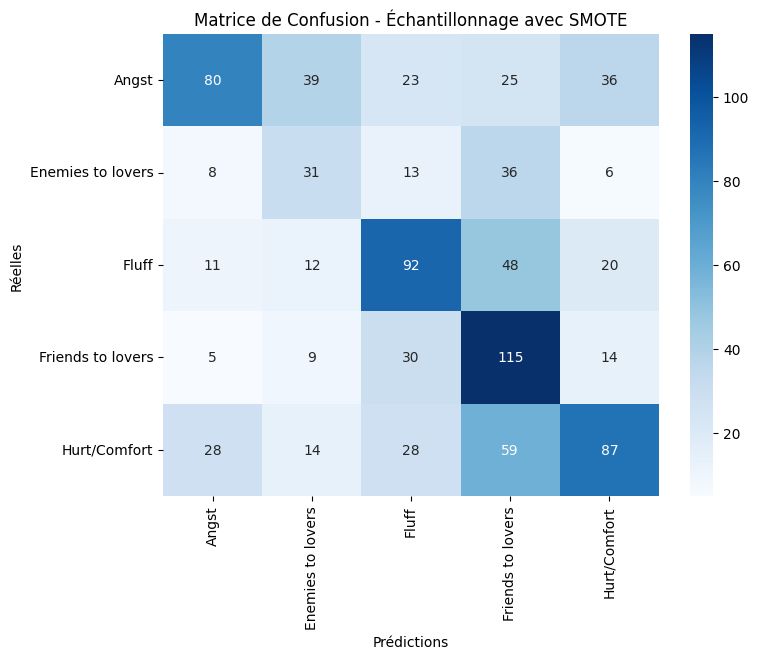

=== Rapport de Test: Pondération + Échantillonnage ===
📊 Pondération des classes et Échantillonnage avec SMOTE
                   precision    recall  f1-score   support

            Angst       0.61      0.39      0.48       203
Enemies to lovers       0.30      0.33      0.31        94
            Fluff       0.49      0.50      0.50       183
Friends to lovers       0.41      0.66      0.50       173
     Hurt/Comfort       0.53      0.40      0.46       216

         accuracy                           0.47       869
        macro avg       0.47      0.46      0.45       869
     weighted avg       0.49      0.47      0.46       869



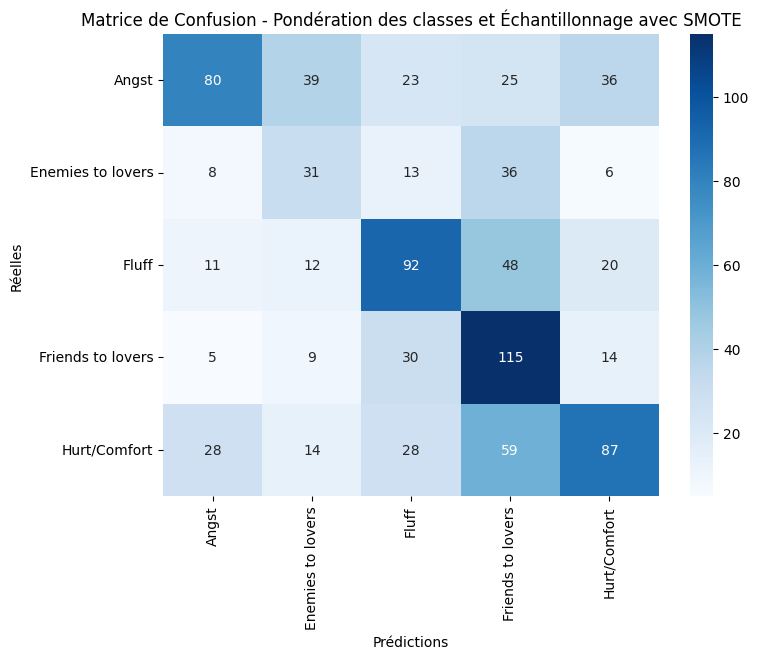

In [ ]:
print("=== Rapport de Test: Pondération ===")
train_and_evaluate(X_dev, y_dev, X_test, y_test, use_smote=False, use_class_weight=True, title="Pondération des classes")

print("=== Rapport de Test: Échantillonnage ===")
train_and_evaluate(X_dev, y_dev, X_test, y_test, use_smote=True, use_class_weight=False, title="Échantillonnage avec SMOTE")

print("=== Rapport de Test: Pondération + Échantillonnage ===")
train_and_evaluate(X_dev, y_dev, X_test, y_test, use_smote=True, use_class_weight=True, title="Pondération des classes et Échantillonnage avec SMOTE")

# Interprétation des résultats

Récupération des caractéristiques discriminantes par les coefficients de LinearSVC.

In [ ]:
# Récupérer le vecteur de mots après vectorisation
feature_names = text_vectorizer.get_feature_names_out()

# Récupérer les coefficients du modèle
coefficients = model_pipeline.named_steps['linearsvc'].coef_

# Créer un dataframe avec les mots et leurs coefficients pour chaque tag
df_coeffs = pd.DataFrame(coefficients, columns=feature_names, index=model.classes_)

# Afficher les 15 mots les plus discriminants pour chaque tag
for tag in model.classes_:
    print(f"\n🔹 Top 15 mots pour {tag} :")
    print(df_coeffs.loc[tag].sort_values(ascending=False).head(15))


🔹 Top 15 mots pour Angst :
sang        1.811251
douleur     1.743862
mort        1.719292
corps       1.600657
rien        1.449297
savait      1.298492
tom         1.281913
sauver      1.263129
devait      1.257785
empereur    1.242860
mourir      1.217207
chose       1.169799
agrippa     1.119853
harry       1.074323
patron      1.049311
Name: Angst, dtype: float64

🔹 Top 15 mots pour Enemies to lovers :
ministre      2.089443
ennemi        2.072430
malefoy       2.052897
arretez       1.900313
lycee         1.754379
rival         1.745961
~             1.689756
air           1.641551
ginny         1.640201
francais      1.624642
serpentard    1.606110
russe         1.593149
brun          1.449355
demon         1.387316
prisonnier    1.386937
Name: Enemies to lovers, dtype: float64

🔹 Top 15 mots pour Fluff :
sourire       3.794703
noel          2.029454
sourit        1.925189
rire          1.758532
enfants       1.681496
ronald        1.587273
alpha         1.510323
neige         1

In [ ]:
def plot_top_words(tag, n=15):
    """ Affiche un graphique des mots les plus discriminants pour un tag donné. """
    top_words = df_coeffs.loc[tag].sort_values(ascending=False).head(n)
    plt.figure(figsize=(8,5))
    plt.barh(top_words.index, top_words.values, color='steelblue')
    plt.xlabel("Coefficient")
    plt.title(f"Top {n} mots pour {tag}")
    plt.gca().invert_yaxis()
    plt.show()

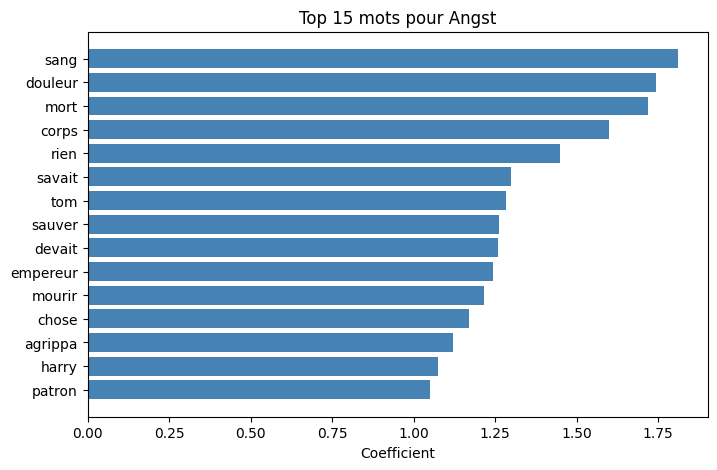

In [ ]:
# Visualiser les mots les plus discriminants pour Angst
plot_top_words("Angst")

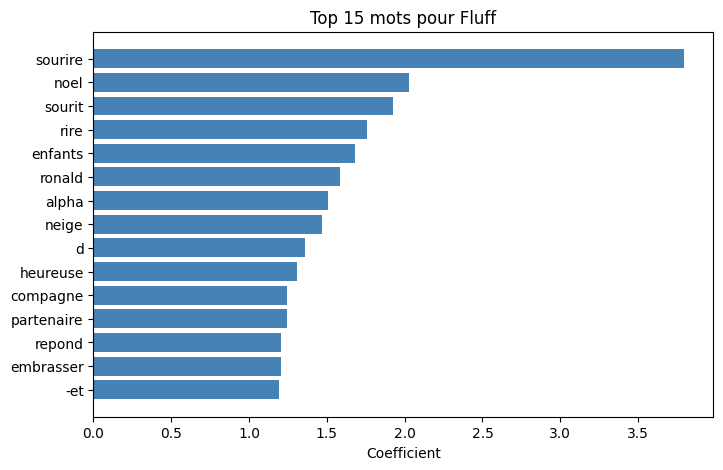

In [ ]:
# Visualiser les mots les plus discriminants pour Angst
plot_top_words("Fluff")

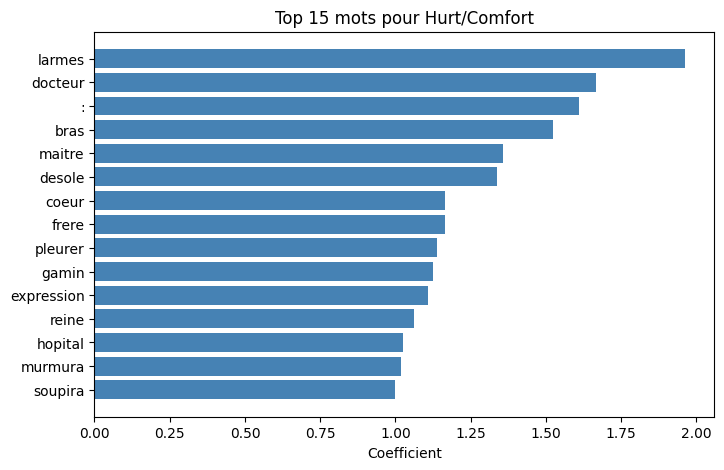

In [ ]:
# Visualiser les mots les plus discriminants pour Angst
plot_top_words("Hurt/Comfort")

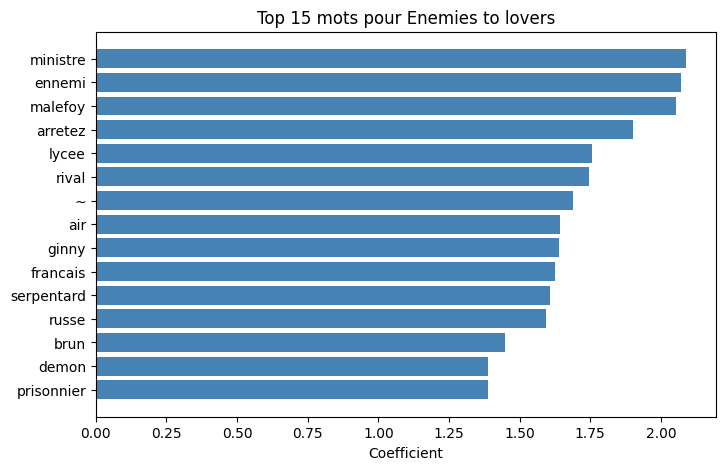

In [ ]:
# Visualiser les mots les plus discriminants pour Angst
plot_top_words("Enemies to lovers")

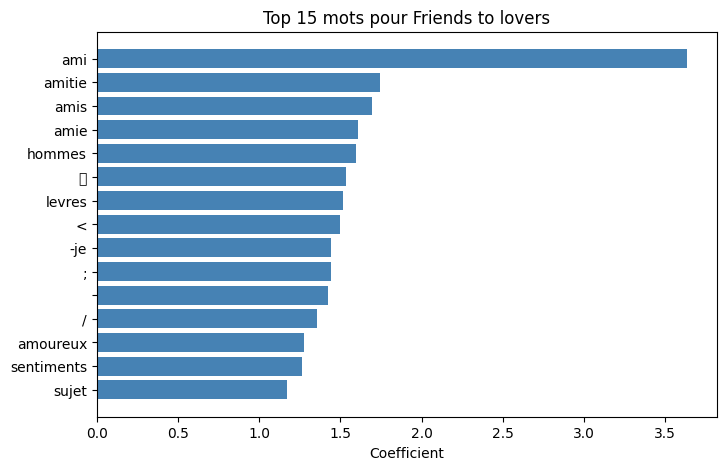

In [ ]:
# Visualiser les mots les plus discriminants pour Angst
plot_top_words("Friends to lovers")

# Entrainement sur données sans ponctuation

### Nettoyer les ponctuations de la colonne utilisée

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Supprimer la ponctuation (sans supprimer les espaces entre les mots)
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Supprimer les espaces en trop
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Appliquer la fonction
df_dev["clean_body_punct"] = df_dev["tokenised_no_chara"].apply(clean_text)
df_test["clean_body_punct"] = df_test["tokenised_no_chara"].apply(clean_text)

df_dev["clean_body_punct"].head()

,clean_body_punct
0,deteste vraiment peine jours rencontre jeune h...
1,reunion fatigante lassante rapports documents ...
2,porte soirees fetes prefere lire faire aime me...
3,chevelure hideuse glissa doigts meches tira ri...
4,allonge canape faisait passes lorsqu entendit ...


### Apprentissage des catégories

In [ ]:
# Données sources
X_dev_clean = df_dev['clean_body_punct']
X_test_clean = df_test['clean_body_punct']

### Entrainement du modèle puis test

📊 Rapport de classification sur le Test Set avec pondération des classes:
                   precision    recall  f1-score   support

            Angst       0.61      0.59      0.60       203
Enemies to lovers       0.38      0.19      0.25        94
            Fluff       0.43      0.61      0.51       183
Friends to lovers       0.49      0.46      0.47       173
     Hurt/Comfort       0.52      0.49      0.50       216

         accuracy                           0.50       869
        macro avg       0.49      0.47      0.47       869
     weighted avg       0.50      0.50      0.49       869



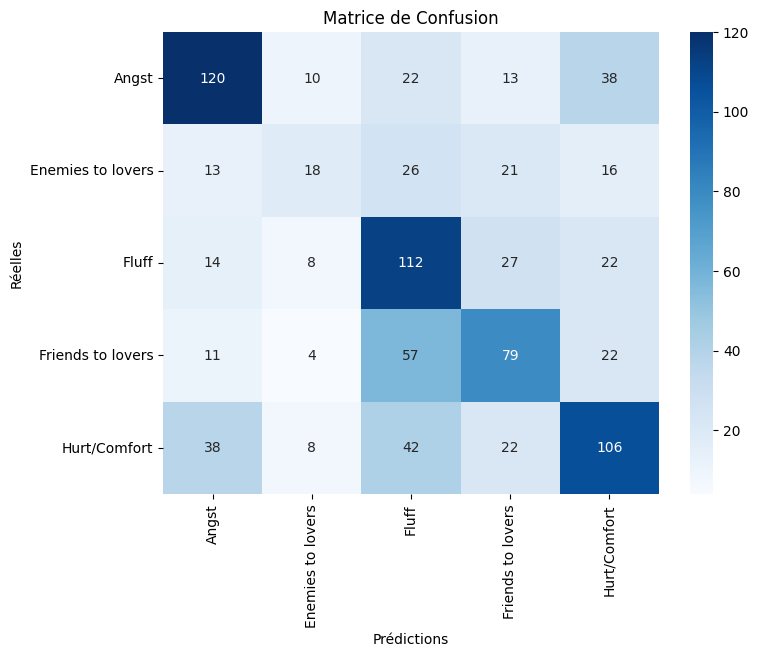

In [ ]:
# Calculer les poids des classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_dev),
                                     y=y_dev)
class_weights_dict = dict(zip(np.unique(y_dev), class_weights))

# Modèle à entraîner avec pondération des classes
model = LinearSVC(C=1, loss='squared_hinge', penalty='l2', tol=0.01,
                  class_weight=class_weights_dict)

# Création de la pipeline pour le modèle
model_pipeline = make_pipeline(text_vectorizer, model)

# Réentraîner le modèle sur tout le jeu de développement
model_pipeline.fit(X_dev_clean, y_dev)

# Prédire sur le jeu de test
y_test_pred = model_pipeline.predict(X_test_clean)

# Afficher le rapport de classification
print("📊 Rapport de classification sur le Test Set avec pondération des classes:")
print(classification_report(y_test, y_test_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_test_pred)

# 📌 Affichage sous forme de heatmap pour une meilleure lisibilité
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Prédictions")
plt.ylabel("Réelles")
plt.title("Matrice de Confusion")
plt.show()

### Interprétation

Récupération des caractéristiques discriminantes sur les textes sans ponctuation.

In [ ]:
# Récupérer le vecteur de mots après vectorisation
feature_names = text_vectorizer.get_feature_names_out()

# Récupérer les coefficients du modèle
coefficients = model_pipeline.named_steps['linearsvc'].coef_

# Créer un dataframe avec les mots et leurs coefficients pour chaque tag
df_coeffs = pd.DataFrame(coefficients, columns=feature_names, index=model.classes_)

# Afficher les 15 mots les plus discriminants pour chaque tag
for tag in model.classes_:
    print(f"\n🔹 Top 15 mots pour {tag} :")
    print(df_coeffs.loc[tag].sort_values(ascending=False).head(15))


🔹 Top 15 mots pour Angst :
tom         1.322018
douleur     1.314319
devait      1.279515
sang        1.272954
mort        1.238437
patron      1.169559
corps       1.146905
sauver      1.134988
chose       1.130850
agrippa     1.103108
bite        1.100085
soldats     1.042614
empereur    0.970999
rien        0.969833
devenir     0.966814
Name: Angst, dtype: float64

🔹 Top 15 mots pour Enemies to lovers :
ginny         2.019471
ennemi        1.850758
russe         1.698561
arretez       1.534274
rival         1.413851
pilote        1.294540
francais      1.293619
present       1.218003
prisonnier    1.163196
of            1.145656
ministre      1.137325
lycee         1.123148
hocha         1.118069
allemand      1.053046
air           1.052766
Name: Enemies to lovers, dtype: float64

🔹 Top 15 mots pour Fluff :
sourire       2.388838
bal           1.452464
noel          1.402535
heureuse      1.305018
rire          1.232696
sourit        1.197616
enfants       1.147496
adorable      1

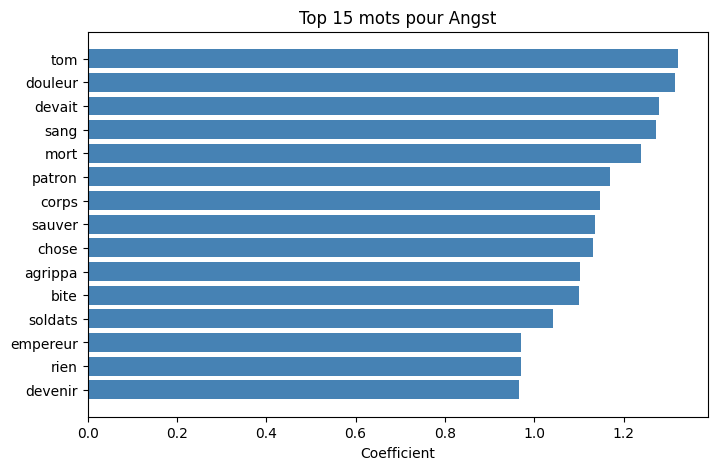

In [ ]:
# Visualiser les mots les plus discriminants
plot_top_words("Angst")

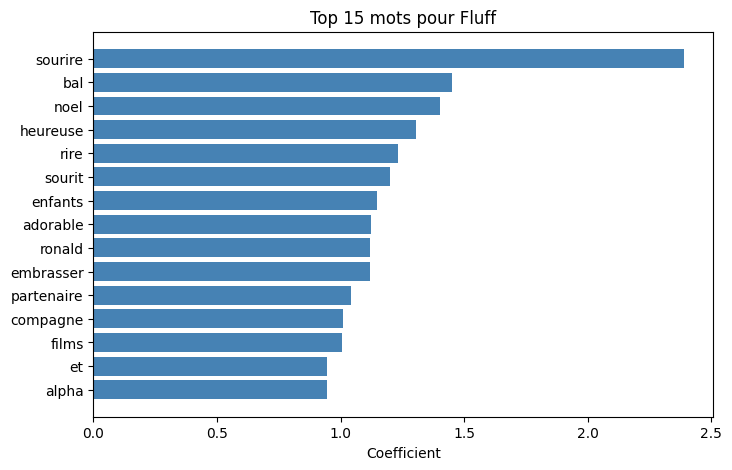

In [ ]:
plot_top_words("Fluff")

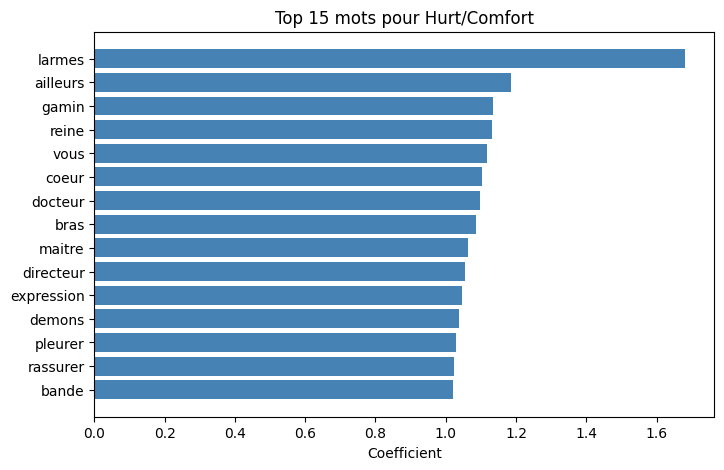

In [ ]:
plot_top_words("Hurt/Comfort")

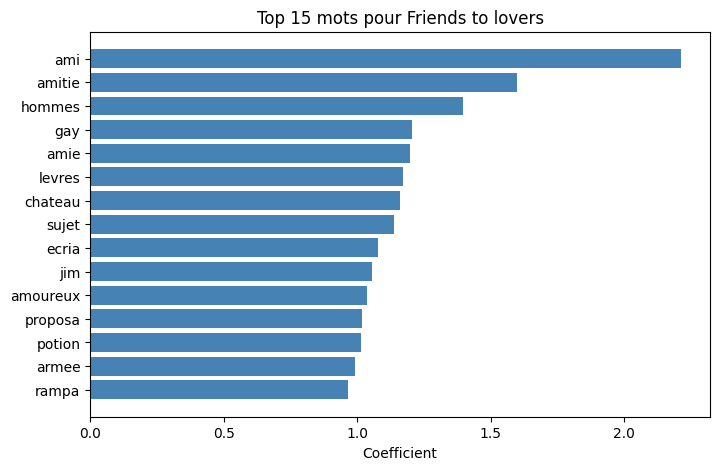

In [ ]:
plot_top_words("Friends to lovers")

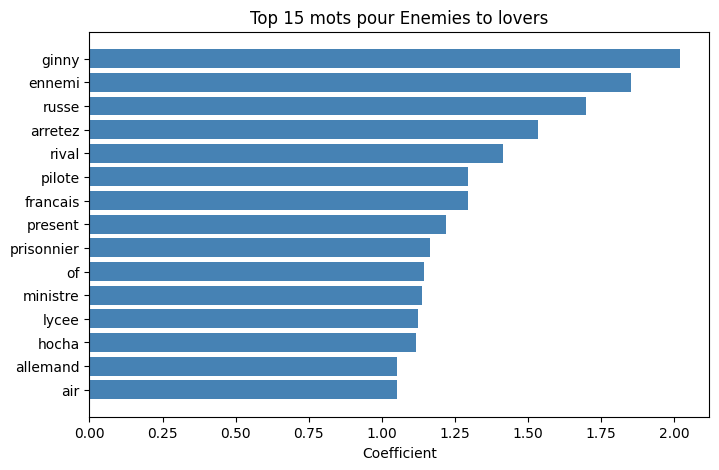

In [ ]:
plot_top_words("Enemies to lovers")